# Optimisation topologique linéaire

In [1]:
# Enlever les  # pour que les figures s'ouvrent dans une fenêtre interactive à part

#%matplotlib qt5
from module_optim_topo import *
from IPython.display import clear_output
from copy import copy
#plt.ion()

Variables globales :

In [2]:
phi_impose = 1

## 1) Maillage

In [3]:
mesh = meshLamDisk(100, h = 1/50)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## 2) Fonction objectif

In [4]:
def fObjectif(ud,uq,mu):
    return compliance(ud, mu, mesh) - compliance(uq, mu, mesh)

def grad_fObjectif(ud,uq): # problème auto-adjoint
    return grad(uq)*grad(uq) - grad(ud)*grad(ud) 

def fracVol(mu,mesh):
    return Integrate((mu-mu0)/(mu0*(mur-1)),mesh) / Integrate(CoefficientFunction(1),mesh)

## 3) Optimisation
### a) Boucle d'optimisation

In [5]:
listeMur = np.logspace(0.3,4,20)

listeMu = []
listeJd = []
listeJq = []
listeJ =[]
listeRhoFrac = []
listeIter = []

for mur in listeMur:

## Initialisation

    alpha = mur*mu0/10     # Pas initial
    alpha_min = 1e-15      # Pas minimal
    alpha_max = mur*mu0/5  # Pas maximal
    n_max = 1000           # Nombre d'itérations de l'algorithme d'optimisation
    n = 0

# Définition de la situation initiale
    spaceMu = L2(mesh)
    mu = GridFunction(spaceMu)
    mu.Set((mu0 + mur*mu0)/2)

    ud, uq = solveDual_linear(mu,phi_impose,mesh)
    objectiveHistory = [fObjectif(ud, uq, mu)]
    muHistory = [copy(mu)]
    fracVolHistory = [fracVol(mu,mesh)]

## Boucle d'optimisation


    while( n < n_max and alpha > alpha_min):
    
    # 1) Calcul de l'état physique :
        ud, uq = solveDual_linear(mu,phi_impose,mesh)
    
    # 2) Calcul du gradient :
        gradient = grad_fObjectif(ud,uq)
    
    # 3) Mise à jour :
        mu_test = GridFunction(spaceMu)
    
    # normalisation du gradient :
        g = 2*atan(gradient)/np.pi
    
    # mise à jour :
        mu_test.Set(mu - alpha *g) 
        n += 1
    
    # 4) Projection :
        mu_test.vec[:].FV().NumPy()[mu_test.vec[:].FV().NumPy()<mu0] = mu0
        mu_test.vec[:].FV().NumPy()[mu_test.vec[:].FV().NumPy()>mu0*mur] = mu0*mur
    
    
    # 5) Contrôle du pas :
        ud_test, uq_test = solveDual_linear(mu_test,phi_impose,mesh)
        objectiveHistory.append(fObjectif(ud_test, uq_test, mu_test))
        clear_output(wait = True)
    
        print(f'mu_r = {mur} | it n°{n} | f = {objectiveHistory[-1]} | pas = {alpha} | frac. vol = {fracVolHistory[-1]}')
    
        if objectiveHistory[-1] >= objectiveHistory[-2]:
            alpha = alpha/2
            objectiveHistory.pop();
        elif objectiveHistory[-1] < objectiveHistory[-2]:
            alpha = min([alpha*1.2,alpha_max])
            mu = mu_test
            muHistory.append(copy(mu))
            fracVolHistory.append(fracVol(mu,mesh))
    
    listeMu.append(copy(muHistory[-1]))
    listeJd.append(compliance(ud, mu, mesh))
    listeJq.append(compliance(uq, mu, mesh))
    listeJ.append(objectiveHistory[-1])
    listeRhoFrac.append(fracVolHistory[-1])
    listeIter.append(n)

mu_r = 10000.0 | it n°451 | f = -749638.2762293295 | pas = 1.1564063685932952e-15 | frac. vol = 0.29734359379389785


### b) Tracés des courbes

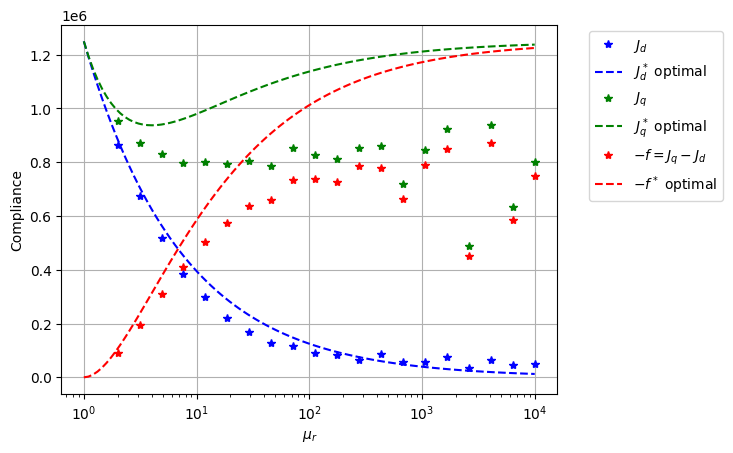

In [6]:
# Tracé de J en fonction de mu_r
plt.figure()
listeMur2 = np.logspace(0.0001,4,100)
listeRhoOpt = (np.sqrt(listeMur2)-1)/(listeMur2-1)
listeMudOpt = listeRhoOpt * listeMur2 * mu0 + (1-listeRhoOpt)*mu0
listeMuqOpt =1/(listeRhoOpt/(listeMur2*mu0) +(1-listeRhoOpt)/mu0 )

plt.semilogx(listeMur,listeJd,'b*', label = '$J_d$')
plt.semilogx(listeMur2, np.pi/2*phi_impose**2/listeMudOpt, 'b--',label = '$J_d^*$ optimal')
plt.semilogx(listeMur,listeJq,'g*', label = '$J_q$')
plt.semilogx(listeMur2, np.pi/2*phi_impose**2/listeMuqOpt, 'g--',label = '$J_q^*$ optimal')
plt.semilogx(listeMur,-np.array(listeJ),'r*', label = '$-f = J_q - J_d$')
plt.semilogx(listeMur2,np.pi/2*phi_impose**2/listeMuqOpt-np.pi/2*phi_impose**2/listeMudOpt,'r--', label = '$-f^*$ optimal')
plt.xlabel('$\mu_r$')
plt.ylabel('Compliance')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

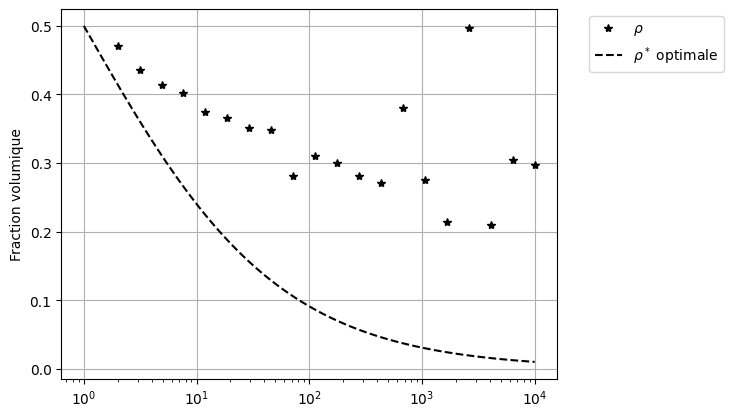

In [7]:
# Tracé de la fraction volumique en fonction de mu_r
plt.figure()
plt.semilogx(listeMur,listeRhoFrac,'k*', label = '$ \\rho $')
plt.semilogx(listeMur2,listeRhoOpt,'k--', label = '$\\rho^*$ optimale')
plt.ylabel('Fraction volumique')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

### c) Tracés des structures

In [9]:
Draw(listeMu[0],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[0]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 1.9952623149688795


In [10]:
Draw(listeMu[4],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[4]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 11.993539462092343


In [11]:
Draw(listeMu[8],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[8]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 72.0932720222353


In [12]:
Draw(listeMu[12],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[12]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 433.35329718965926


In [13]:
Draw(listeMu[15],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[15]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 1663.6142493842228


In [14]:
Draw(listeMu[-1],mesh, settings = {'mesh' : False, 'edges' : False})
print(f'mur = {listeMur[-1]}')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'mesh': False, 'edges': False…

mur = 10000.0
